In [1]:
# Standard library imports
import time
import concurrent.futures
from math import tanh, sqrt, fabs, erf as math_erf

# Third-party imports

# Numerical computations
import numpy as np
from numpy.polynomial import Chebyshev

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.widgets import Slider

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, Output, RadioButtons

# Scientific computing
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.interpolate import UnivariateSpline, interp1d

# Performance enhancement
from numba import njit

# Workflow for Color Fringe Computation and Chromatic Correction
This document outlines the steps needed to simulate chromatic aberration effects, including data import, interpolation, interactive curve fitting, and analysis of color fringe width. The simulation takes into account the physics of chromatic aberration, sensor response, and overexposure effects.

## 1. Data Import

In [2]:
# Wavelength ranges
wvl_chl = np.arange(400, 701, 10)
wvl_day = np.arange(380, 691, 10)
wvl_sensor = np.arange(400, 701, 10)

# Corresponding values
def stack_data(wavelengths, values):
    return np.column_stack((wavelengths, values))

CHLzf85 = stack_data(wvl_chl, [
    285, 190, 118,  63,  22,  -9, -31, -46, -56, -62,
     -64, -63, -60, -54, -48, -39, -30, -20,  -9,   3,
      15,  28,  41,  54,  68,  82,  96, 111, 125, 139,
     156
])

Daylight_in = stack_data(wvl_day, [
     11,  16,  22,  33,  48,  62,  71,  78,  84,  92,
     97, 100,  96,  95,  95,  94,  90,  78,  70,  78,
     88,  94,  91,  85,  82,  85,  92, 100,  89,  76,
     83, 100
])

# Sensor responses per channel
sensor_vals = {
    "Blue": [
        0.42, 9.08, 24.34, 28.37, 40.12, 39.01, 47.12, 46.65, 41.14, 26.73,
        14.75, 7.55, 2.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.69, 0.84, 0.32, 0.04, 0.0
    ],
    "Green": [
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.63, 6.48, 9.09,
        17.75, 28.39, 37.8, 38.39, 35.02, 28.83, 28.1, 19.02, 13.1, 6.96,
        4.33, 3.34, 3.02, 0.0, 0.0, 0.0, 0.69, 0.7, 0.34, 0.05, 0.0
    ],
    "Red": [
        0.0, 1.3, 1.86, 2.17, 1.73, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.38, 60.18, 100.0,
        92.73, 72.75, 50.6, 35.81, 35.08, 22.4, 16.96, 7.75, 3.3, 0.78, 0.18
    ]
}

sensors = {name: stack_data(wvl_sensor, vals) for name, vals in sensor_vals.items()}
SensorBlue, SensorGreen, SensorRed = sensors['Blue'], sensors['Green'], sensors['Red']

# Verify shapes
for name, arr in [('CHLzf85', CHLzf85), ('Daylight', Daylight_in), *sensors.items()]:
    print(f"{name} shape: {arr.shape}")

CHLzf85 shape: (31, 2)
Daylight shape: (32, 2)
Blue shape: (31, 2)
Green shape: (31, 2)
Red shape: (31, 2)


In [3]:
def CHLfit_poly(lam_nm):
    return np.polyval(CHL_coeffs, lam_nm)

def CHLfit_conrady(lam_nm, A, B, C):
    return A + B/lam_nm + C/lam_nm**3.5       # µm

lam_CHL, defocus_CHL = CHLzf85[:, 0], CHLzf85[:, 1]
lam_fit = np.linspace(400, 700, 301)
nu_CHL = 1.0 / lam_CHL    # nm⁻¹
nu_fit  = 1.0 / lam_fit    # nm⁻¹

CHL_coeffs = np.polyfit(lam_CHL, defocus_CHL, 6)
print("CHL fit coefficients:", CHL_coeffs)
defocus_fit_poly = CHLfit_poly(lam_fit)

p0 = (0.0, 1e5, -1e11)                        # initial guesses
popt, pcov = curve_fit(CHLfit_conrady, lam_CHL, defocus_CHL, p0=p0)
A, B, C = popt
print(f"Conrady coefficients:\n"
      f"   A = {A:.4f} µm   B = {B:.4e} µm·nm   C = {C:.4e} µm·nm³·⁵")
defocus_fit_conr = CHLfit_conrady(lam_fit, *popt)         # µm

CHL fit coefficients: [ 6.17055255e-12 -2.17284405e-08  3.18690992e-05 -2.49424071e-02
  1.09994225e+01 -2.59404221e+03  2.55683162e+05]
Conrady coefficients:
   A = 2018.5575 µm   B = -1.4912e+06 µm·nm   C = 2.5152e+12 µm·nm³·⁵


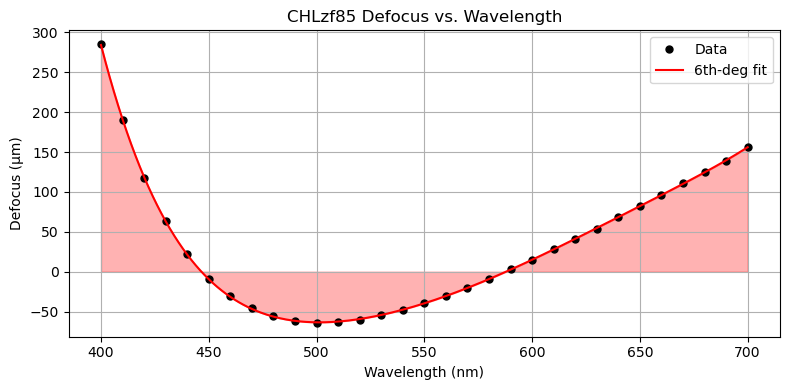

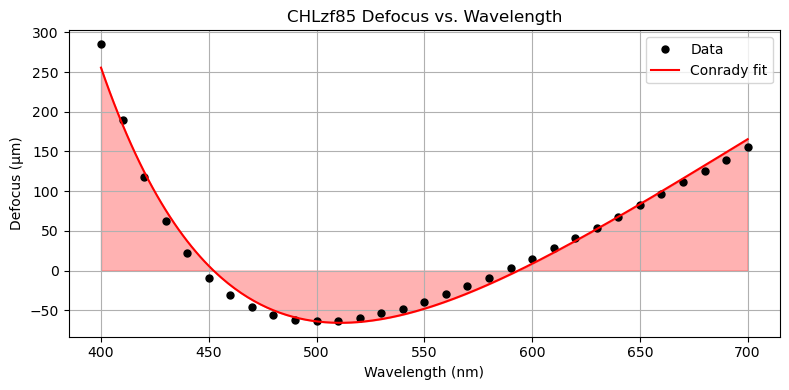

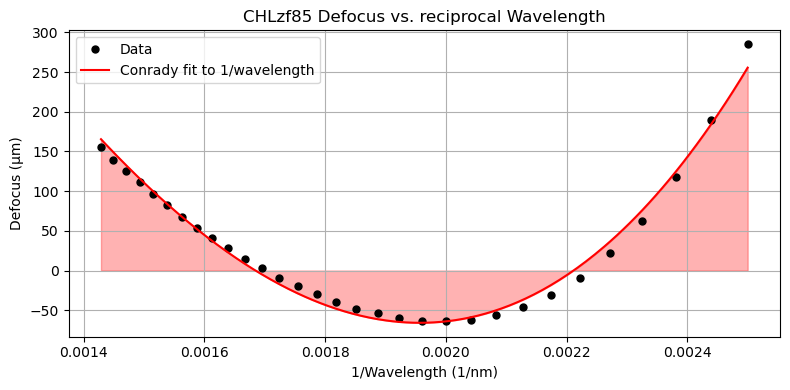

In [4]:
plt.figure(figsize=(8, 4))
plt.plot(lam_CHL, defocus_CHL, 'o', color='black', markersize=5, label='Data')
plt.plot(lam_fit, defocus_fit_poly, '-', color='red', label='6th-deg fit')
plt.fill_between(lam_fit, defocus_fit_poly, color='red', alpha=0.3)
plt.title('CHLzf85 Defocus vs. Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Defocus (µm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(lam_CHL, defocus_CHL, 'o', color='black', markersize=5, label='Data')
plt.plot(lam_fit, defocus_fit_conr, '-', color='red', label='Conrady fit')
plt.fill_between(lam_fit, defocus_fit_conr, color='red', alpha=0.3)
plt.title('CHLzf85 Defocus vs. Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Defocus (µm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(nu_CHL, defocus_CHL, 'o', color='black', markersize=5, label='Data')
plt.plot(nu_fit, defocus_fit_conr, '-', color='red', label='Conrady fit to 1/wavelength')
plt.fill_between(nu_fit, defocus_fit_conr, color='red', alpha=0.3)
plt.title('CHLzf85 Defocus vs. reciprocal Wavelength')
plt.xlabel('1/Wavelength (1/nm)')
plt.ylabel('Defocus (µm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
def resample_poly(spectrum, new_waves, degree=6):
    w, inten = spectrum[:,0], spectrum[:,1]
    coeffs = np.polyfit(w, inten, degree)
    y = np.poly1d(coeffs)(new_waves)
    return np.column_stack((new_waves, y / y.max() * 100))

# Compute normalization factor so ∫(sensor·illuminant) dλ = 1
def norm_factor(sensor, illuminant):
    lam = sensor[:,0]
    raw = np.trapezoid(sensor[:,1] * illuminant[:,1], x=lam)
    return (1/raw if raw else 0), raw

# Plot helper: line + fill
def plot_curve(data, color, label):
    lam, inten = data[:,0], data[:,1]
    plt.plot(lam, inten, color=color, label=label)
    plt.fill_between(lam, inten, alpha=0.3)

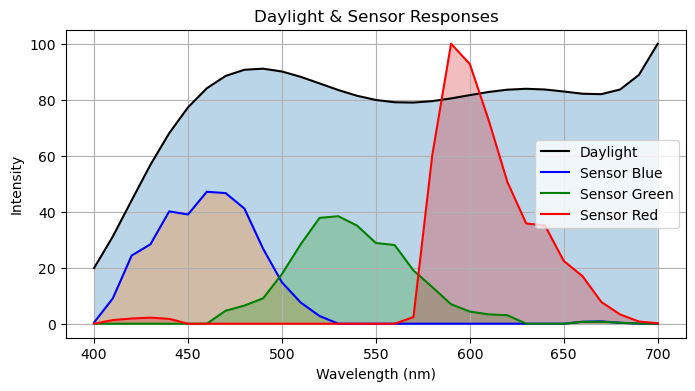

Sensor Blue: raw ∫=253598.07, factor=3.9432e-06
Sensor Green: raw ∫=238856.89, factor=4.1866e-06
Sensor Red: raw ∫=413821.66, factor=2.4165e-06


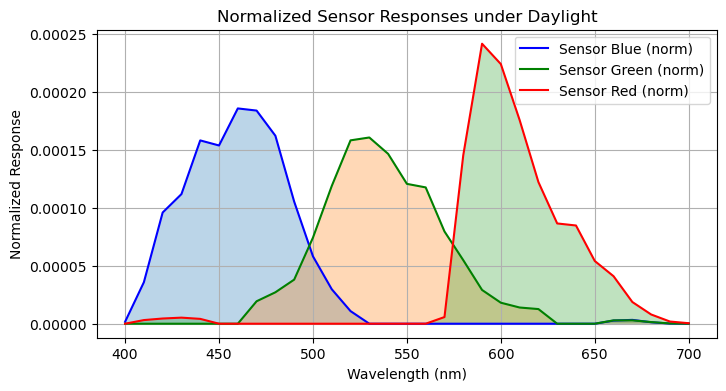

Shapes: (31, 2) (31, 2) (31, 2)


In [6]:
# === Part 1: Resample & Plot ===
Daylight = resample_poly(Daylight_in, lam_CHL)
plt.figure(figsize=(8,4))
plot_curve(Daylight, 'k', 'Daylight')

# Raw sensor curves
default_colors = {'Sensor Blue':'blue', 'Sensor Green':'green', 'Sensor Red':'red'}
sensors = {'Sensor Blue':SensorBlue, 'Sensor Green':SensorGreen, 'Sensor Red':SensorRed}
for name, data in sensors.items():
    plot_curve(data, default_colors[name], name)

plt.title('Daylight & Sensor Responses')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.legend(); plt.grid(True)
plt.show()

# === Part 2: Normalize & Plot ===
plt.figure(figsize=(8,4))
normed = {}
for name, data in sensors.items():
    factor, raw_int = norm_factor(data, Daylight)
    norm_data = data.copy()
    norm_data[:,1] *= factor
    normed[name] = norm_data
    print(f"{name}: raw ∫={raw_int:.2f}, factor={factor:.4e}")
    plot_curve(norm_data, default_colors[name], f"{name} (norm)")

plt.title('Normalized Sensor Responses under Daylight')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Response')
plt.legend(); plt.grid(True)
plt.show()

# Expose normalized arrays for further use
SensorBlue_norm = normed['Sensor Blue']
SensorGreen_norm = normed['Sensor Green']
SensorRed_norm = normed['Sensor Red']

print("Shapes:", SensorBlue_norm.shape, SensorGreen_norm.shape, SensorRed_norm.shape)


## 2. CHL Curve Modification and Visualization

In [7]:
# Pre-calculations and Setup
dlam = lam_fit[1] - lam_fit[0]
min_idx = np.argmin(defocus_fit_poly)
lam_min, defocus_min = lam_fit[min_idx], defocus_fit_poly[min_idx]
print("Original lowest point at λ = {:.2f} nm, defocus = {:.2f} µm".format(lam_min, defocus_min))

# rebuild your interpolators/splines on the correct arrays
linear_fit = interp1d(lam_fit, defocus_fit_poly, kind='linear', fill_value="extrapolate")
spline_fit = UnivariateSpline(lam_fit, defocus_fit_poly, s=0)

Original lowest point at λ = 501.00 nm, defocus = -63.42 µm


In [8]:
def CHLfit_mod_overall(lam_vals: np.ndarray, lam_shift: float = 0.0, tilt: float = 0.0):
    """
    Apply a horizontal shift and tilt to modify the CHL curve.
    For lam < pivot: derivative scaled by (1 - tilt)
    For lam >= pivot: derivative scaled by (1 + tilt)
    
    Parameters:
        lam_vals (array): Wavelength values.
        lam_shift (float): Pivot shift.
        tilt (float): Tilt factor.
    
    Returns:
        np.ndarray: Modified CHL curve values.
    """
    # Determine the local spacing for the current x_vals
    local_dlam = lam_vals[1] - lam_vals[0]
    
    pivot_lam    = lam_min + lam_shift  
    pivot_defocus = CHLfit_poly(lam_min)  # External CHL evaluation function
    lam_shifted  = lam_vals - lam_shift
    
    deriv_left  = spline_fit.derivative()(lam_shifted)
    deriv_right = np.gradient(linear_fit(lam_shifted), local_dlam)
    base_deriv   = np.where(lam_vals < pivot_lam, deriv_left, deriv_right)
    new_deriv    = np.where(lam_vals < pivot_lam, base_deriv * (1 - tilt), base_deriv * (1 + tilt))
    
    g = np.empty_like(lam_vals)
    pivot_idx = np.argmin(np.abs(lam_vals - pivot_lam))
    g[pivot_idx] = pivot_defocus
    # integrate forwards
    if pivot_idx < len(lam_vals) - 1:
        g[pivot_idx + 1:] = pivot_defocus + np.cumsum(new_deriv[pivot_idx:-1]) * local_dlam
    # integrate backwards
    if pivot_idx > 0:
        g[:pivot_idx] = pivot_defocus - np.cumsum(new_deriv[1:pivot_idx + 1][::-1])[::-1] * local_dlam
    
    return g

def extract_sampled_modified_values_overall(lam_shift=0.0, tilt=0.0):
    """
    Sample the modified CHL curve every 10 nm from 400 nm to 700 nm.
    
    Returns:
        np.ndarray: Two-column array (wavelength, floored defocus value).
    """
    lam_sample    = np.arange(400, 701, 10)
    defocus_sample = CHLfit_mod_overall(lam_sample, lam_shift, tilt)
    return np.column_stack((lam_sample, np.floor(defocus_sample)))

# Global variable to store the sampled modified defocus values
global_defocus_fit = None  

def get_modified_defocus_array(lam_shift=0.0, tilt=0.0):
    """Update and return the global defocus array based on lam_shift and tilt."""
    global global_defocus_fit
    global_defocus_fit = extract_sampled_modified_values_overall(lam_shift, tilt)
    return global_defocus_fit

def plot_defocus_overall(lam_shift=0.0, tilt=0.0):
    """Plot the modified defocus curve along with original input data and key markers."""
    # compute over the full lam_fit grid
    defocus_vals = CHLfit_mod_overall(lam_fit, lam_shift, tilt)
    
    plt.figure(figsize=(8, 4))
    plt.plot(lam_fit, defocus_vals, lw=2, label='Modified Defocus Curve')
    plt.scatter(lam_CHL, defocus_CHL, color='red', label='Input Defocus Data')
    plt.scatter([lam_min], [defocus_min], color='green', s=100, label='Original Pivot λ')
    plt.scatter([lam_min + lam_shift], [CHLfit_poly(lam_min)], color='blue', s=100, label='Shifted Main Wavelength')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Defocus (μm)')
    plt.title('Interactive Updated Defocus Curve with Shift and Tilt')
    plt.legend()
    plt.grid(True)
    plt.xlim(400, 700)
    plt.ylim(-100, 700)
    plt.show()

# Setup interactive sliders for lam_shift and tilt
lam_shift_slider = FloatSlider(min=-80, max=80, step=1, value=0, description='λ Shift (nm)')
tilt_slider      = FloatSlider(min=-0.8, max=0.8, step=0.01, value=0, description='Tilt Factor')
out              = Output()

def update_display(lam_shift, tilt):
    """Update the plot and global defocus array when slider values change."""
    with out:
        out.clear_output(wait=True)
        plot_defocus_overall(lam_shift, tilt)
        updated_array = get_modified_defocus_array(lam_shift, tilt)
        print("Updated global_defocus_fit array:")
        print(updated_array)

In [9]:
interact(update_display, lam_shift=lam_shift_slider, tilt=tilt_slider)
display(out)

interactive(children=(FloatSlider(value=0.0, description='λ Shift (nm)', max=80.0, min=-80.0, step=1.0), Float…

Output()

In [10]:
def CHLfit_mod_overall_defshift(lam_vals: np.ndarray, defocus_shift: float = 0.0, tilt: float = 0.0):
    # Determine the local spacing for the current x_vals
    local_dlam = lam_vals[1] - lam_vals[0]
    
    pivot_lam    = lam_min
    pivot_defocus = CHLfit_poly(lam_min) + defocus_shift  # External CHL evaluation function
    
    deriv_left  = spline_fit.derivative()(lam_vals)
    deriv_right = np.gradient(linear_fit(lam_vals), local_dlam)
    base_deriv   = np.where(lam_vals < pivot_lam, deriv_left, deriv_right)
    new_deriv    = np.where(lam_vals < pivot_lam, base_deriv * (1 - tilt), base_deriv * (1 + tilt))
    
    g = np.empty_like(lam_vals)
    pivot_idx = np.argmin(np.abs(lam_vals - pivot_lam))
    g[pivot_idx] = pivot_defocus
    # integrate forwards
    if pivot_idx < len(lam_vals) - 1:
        g[pivot_idx + 1:] = pivot_defocus + np.cumsum(new_deriv[pivot_idx:-1]) * local_dlam
    # integrate backwards
    if pivot_idx > 0:
        g[:pivot_idx] = pivot_defocus - np.cumsum(new_deriv[1:pivot_idx + 1][::-1])[::-1] * local_dlam
    
    return g

def extract_sampled_modified_values_overall_defshift(defocus_shift=0.0, tilt=0.0):
    lam_sample    = np.arange(400, 701, 10)
    defocus_sample = CHLfit_mod_overall_defshift(lam_sample, defocus_shift, tilt)
    return np.column_stack((lam_sample, np.floor(defocus_sample)))

# Global variable to store the sampled modified defocus values
global_defocus_fit_defshift = None  

def get_modified_defocus_array_defshift(defocus_shift=0.0, tilt=0.0):
    global global_defocus_fit_defshift
    global_defocus_fit_defshift = extract_sampled_modified_values_overall_defshift(defocus_shift, tilt)
    return global_defocus_fit_defshift

def plot_defocus_overall_defshift(defocus_shift=0.0, tilt=0.0):
    defocus_vals = CHLfit_mod_overall_defshift(lam_fit, defocus_shift, tilt)
    
    plt.figure(figsize=(8, 4))
    plt.plot(lam_fit, defocus_vals, lw=2, label='Modified Defocus Curve')
    plt.scatter(lam_CHL, defocus_CHL, color='red', label='Input Defocus Data')
    plt.scatter([lam_min], [defocus_min], color='green', s=100, label='Original Pivot λ')
    plt.scatter([lam_min], [CHLfit_poly(lam_min) + defocus_shift], color='blue', s=100, label='Shifted Main Wavelength')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Defocus (μm)')
    plt.title('Interactive Updated Defocus Curve with Shift and Tilt')
    plt.legend()
    plt.grid(True)
    plt.xlim(400, 700)
    plt.ylim(-200, 700)
    plt.show()

# Setup interactive sliders for lam_shift and tilt
defocus_shift_slider = FloatSlider(min=-100, max=100, step=1, value=0, description='defocus Shift (µm)')
tilt_slider      = FloatSlider(min=-0.8, max=0.8, step=0.01, value=0, description='Tilt Factor')
out              = Output()

def update_display_defshift(defocus_shift, tilt):
    """Update the plot and global defocus array when slider values change."""
    with out:
        out.clear_output(wait=True)
        plot_defocus_overall_defshift(defocus_shift, tilt)
        updated_array_defshift = get_modified_defocus_array_defshift(defocus_shift, tilt)
        print("Updated global_defocus_fit array:")
        print(updated_array_defshift)

In [11]:
interact(update_display_defshift, defocus_shift=defocus_shift_slider, tilt=tilt_slider)
display(out)

interactive(children=(FloatSlider(value=0.0, description='defocus Shift (µm)', min=-100.0, step=1.0), FloatSli…

Output()

In [25]:
from ipywidgets import VBox

# 3.  Pivot λ₀ setup
lam0 = 546.1           # nm (e-line)
nu0 = 1.0 / lam0       # pivot frequency
# Compute Δz at pivot for center A0
def compute_A0():
    return CHLfit_conrady(lam0, A, B, C)
A0 = compute_A0()

# 4.  Pivot-form Conrady
def conrady_pivot(lam_nm, A_p, B_p, C_p):
    nu = 1.0 / lam_nm
    return A_p + B_p*(nu - nu0) + C_p*((nu**3.5) - (nu0**3.5))

# 5.  Sliders for A0, B, C (±50%)
def make_slider(param, label, frac=0.5, n_steps=120, fmt='.2e'):
    span = frac * abs(param)
    step = span / n_steps if span else 1
    return FloatSlider(
        description=label,
        min=param - span,
        max=param + span,
        step=step,
        value=param,
        readout_format=fmt
    )

A_slider = make_slider(A0,      'A (µm)', fmt='.2f')
B_slider = make_slider(B,   'B (µm·nm)')
C_slider = make_slider(C, 'C (µm·nm³·⁵)')

# 6.  Fine grid
lam_fine = np.linspace(400, 700, 301)

# 7.  Interactive update and plotting
out = Output()

def update(A_p, B_p, C_p):
    with out:
        out.clear_output(wait=True)
        dz_fine = conrady_pivot(lam_fine, A_p, B_p, C_p)
        dz_calc = conrady_pivot(lam_CHL, A_p, B_p, C_p)
        CHL_array = stack_data(lam_CHL, np.floor(dz_calc))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
        ax1.plot(lam_CHL, defocus_CHL, 'ko', label='measured')
        ax1.plot(lam_fine, dz_fine, 'r-', label='pivot-Conrady')
        ax1.axvline(lam0, color='grey', ls=':', lw=1)
        ax1.set(xlabel='λ (nm)', ylabel='Δz (µm)', title='Δz vs λ')
        ax1.grid(True); ax1.legend()

        ax2.plot(nu_CHL, defocus_CHL, 'ko')
        ax2.plot(nu_fit, dz_fine, 'r-')
        ax2.invert_xaxis()
        ax2.axvline(nu0, color='grey', ls=':', lw=1)
        ax2.set(xlabel='ν (nm⁻¹)', title='Δz vs ν')
        ax2.grid(True)
        for ax in (ax1, ax2): ax.set_ylim(-500, 1000)
        plt.tight_layout(); plt.show()

        print(f"A = {A_p:+.2f} µm   B = {B_p:+.2e} µm·nm   C = {C_p:+.2e} µm·nm³·⁵")
        print("Sampled CHL array (λ, ⌊Δz⌋):")
        print(CHL_array)

ui = VBox([A_slider, B_slider, C_slider])
interact(update, A_p=A_slider, B_p=B_slider, C_p=C_slider)
display(out)

interactive(children=(FloatSlider(value=-51.193681378593396, description='A (µm)', max=-25.596840689296698, mi…

Output()

In [28]:
from ipywidgets import FloatSlider, interact, Output, VBox
import numpy as np
import matplotlib.pyplot as plt

# --- 1.  Original Conrady formula (no pivot) -------------------------------
def conrady(lam_nm, A, B, C):
    """λ in nm, coefficients in μm, μm·nm, μm·nm³·⁵ → Δz in μm"""
    nu = 1.0 / lam_nm
    return A + B * nu + C * nu**3.5          # same as A + B/λ + C/λ³·⁵

# --- 2.  Sliders for the three coefficients --------------------------------
def make_slider(param, label, frac=0.5, n_steps=120, fmt='.2e'):
    span = frac * (abs(param) if param else 1.0)
    step = span / n_steps
    return FloatSlider(
        description=label, min=param - span, max=param + span,
        step=step, value=param, readout_format=fmt
    )

A_slider = make_slider(A, 'A (µm)', fmt='.2f')
B_slider = make_slider(B, 'B (µm·nm)')
C_slider = make_slider(C, 'C (µm·nm³·⁵)')

# --- 3.  Fine grid for smooth plotting -------------------------------------
lam_fine = np.linspace(400, 700, 301)        # nm
nu_fine  = 1.0 / lam_fine

# --- 4.  Interactive update & plotting -------------------------------------
out = Output()

def update(A_p, B_p, C_p):
    with out:
        out.clear_output(wait=True)

        dz_fine = conrady(lam_fine, A_p, B_p, C_p)
        dz_calc = conrady(lam_CHL,  A_p, B_p, C_p)
        CHL_array = stack_data(lam_CHL, np.floor(dz_calc))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

        # Δz versus wavelength
        ax1.plot(lam_CHL, defocus_CHL, 'ko', label='measured')
        ax1.plot(lam_fine, dz_fine, 'r-',  label='Conrady fit')
        ax1.set(xlabel='λ  [nm]', ylabel='Δz  [µm]', title='Δz vs λ')
        ax1.grid(True); ax1.legend()

        # Δz versus inverse wavelength
        ax2.plot(1/lam_CHL, defocus_CHL, 'ko')
        ax2.plot(nu_fine, dz_fine, 'r-')
        ax2.invert_xaxis()                     # conventional orientation
        ax2.set(xlabel='ν = 1/λ  [nm⁻¹]', title='Δz vs ν')
        ax2.grid(True)

        for ax in (ax1, ax2):
            ax.set_ylim(-500, 1000)

        plt.tight_layout(); plt.show()

        print(f"A = {A_p:+.2f} µm   "
              f"B = {B_p:+.2e} µm·nm   "
              f"C = {C_p:+.2e} µm·nm³·⁵")
        print("Sampled CHL array (λ, ⌊Δz⌋):")
        print(CHL_array)

# --- 5.  Launch the widget --------------------------------------------------
ui = VBox([A_slider, B_slider, C_slider])
interactive_plot = interact(
    update,
    A_p=A_slider,
    B_p=B_slider,
    C_p=C_slider
)

display(out)  


interactive(children=(FloatSlider(value=2018.557482929177, description='A (µm)', max=3027.8362243937654, min=1…

Output()

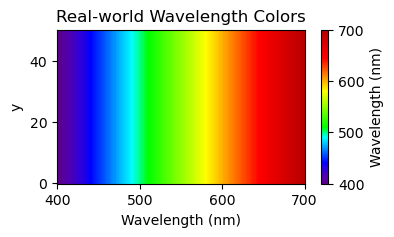

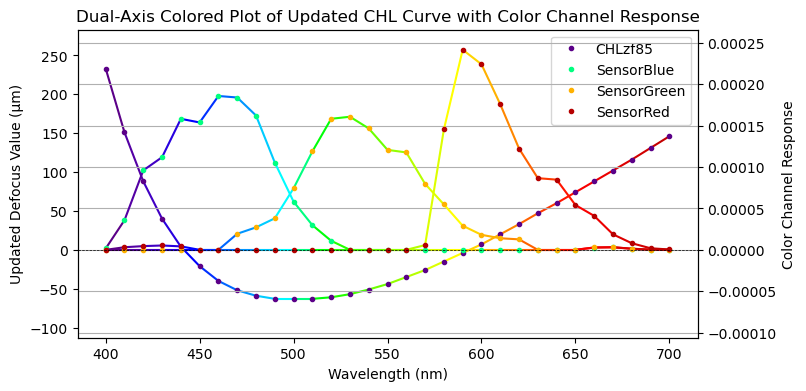

In [14]:
def wavelength_to_rgb(wavelength, gamma_cmap=1):
    """Convert wavelength (nm) to an approximate RGB value."""
    if 380 <= wavelength < 440:
        att = 0.3 + 0.7*(wavelength - 380)/60.0
        return (((440 - wavelength)/60.0 * att)**gamma_cmap, 0.0, (att)**gamma_cmap)
    elif 440 <= wavelength < 490:
        return (0.0, ((wavelength - 440)/50.0)**gamma_cmap, 1.0)
    elif 490 <= wavelength < 510:
        return (0.0, 1.0, ((510 - wavelength)/20.0)**gamma_cmap)
    elif 510 <= wavelength < 580:
        return (((wavelength - 510)/70.0)**gamma_cmap, 1.0, 0.0)
    elif 580 <= wavelength < 645:
        return (1.0, ((645 - wavelength)/65.0)**gamma_cmap, 0.0)
    elif 645 <= wavelength <= 780:
        att = 0.3 + 0.7*(780 - wavelength)/135.0
        return ((att)**gamma_cmap, 0.0, 0.0)
    else:
        return (0.0, 0.0, 0.0)

# Create custom colormap from 400 to 700 nm using lam_fit instead of wavelengths
colors = [wavelength_to_rgb(w) for w in lam_fit]
cmap = mcolors.LinearSegmentedColormap.from_list("wavelength_cmap", colors)

# -------------------------------
# Density Plot using pcolormesh with Wavelength Colors
# -------------------------------
y_vals = np.linspace(0, 50, 100)
X, Y = np.meshgrid(lam_fit, y_vals)
Z = X  # the x-coordinate (wavelength) as data
plt.figure(figsize=(4, 2))
plt.pcolormesh(X, Y, Z, shading='auto', cmap=cmap)
plt.colorbar(label='Wavelength (nm)')
plt.title('Real-world Wavelength Colors')
plt.xlabel('Wavelength (nm)')
plt.ylabel('y')
plt.show()

# -------------------------------
# Dual-Axis Plot: Global CHLfit and Sensor Data
# -------------------------------
def plot_gradient(ax, x, y, cmap):
    """Plot line segments between adjacent points colored by wavelength."""
    norm = plt.Normalize(400, 700)
    for j in range(len(x) - 1):
        ax.plot(x[j:j+2], y[j:j+2], color=cmap(norm(x[j])))

# Define global y-axis limits and margins.
global_min, global_max = -80, 250
margin = 0.1 * (global_max - global_min)
g_min, g_max = global_min - margin, global_max + margin
r = (0 - g_min) / (g_max - g_min)

# Compute sensor data limits.
sens_max = max(SensorBlue_norm[:, 1].max(),
               SensorGreen_norm[:, 1].max(),
               SensorRed_norm[:, 1].max())
sens_margin = 0.1 * sens_max
sens_max_new = sens_max + sens_margin
sens_min_new = - (r / (1 - r)) * sens_max_new

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()
ax1.set_ylim(g_min, g_max)
ax2.set_ylim(sens_min_new, sens_max_new)

# Plot global CHLfit data.
plot_gradient(ax1, global_defocus_fit[:, 0], global_defocus_fit[:, 1], cmap)
ax1.plot(global_defocus_fit[:, 0], global_defocus_fit[:, 1], 'o', markersize=3, color=cmap(0), label='CHLzf85')

# Plot sensor data.
sensors = [SensorBlue_norm, SensorGreen_norm, SensorRed_norm]
sensor_names = ['SensorBlue', 'SensorGreen', 'SensorRed']
for i, (sensor, name) in enumerate(zip(sensors, sensor_names), start=1):
    plot_gradient(ax2, sensor[:, 0], sensor[:, 1], cmap)
    ax2.plot(sensor[:, 0], sensor[:, 1], 'o', markersize=3, color=cmap(i/3), label=name)

# Add horizontal reference lines, labels, and legends.
ax1.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax2.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Updated Defocus Value (μm)')
ax2.set_ylabel('Color Channel Response')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
plt.title('Dual-Axis Colored Plot of Updated CHL Curve with Color Channel Response')
plt.grid(True)
plt.show()

In [15]:
# --------------------------------------------------------------------
# Setup for Sensor Data Processing, Edge Functions & Grid Search
# --------------------------------------------------------------------
# Data Setup for Sensor Channels:
#   - Convert sensor data from the normalized sensor arrays to NumPy arrays
#     with float64 precision for accurate computations.
#
# Global Constants and Parameters:
#   - K: A constant used in sensor data processing or modeling.
#   - xrange_val: Range for x values in plots (e.g., visualization limits).
#   - defocusrange: Controls the defocus range during focus analysis.
#   - tol: Tolerance value for color width calculations.
#   - F_value: Parameter used in model fitting or sensor data processing.
#   - g_value: Parameter likely related to sensor processing or edge function computation.
# --------------------------------------------------------------------

# Data Setup for Sensor Channels
SensorBluedata = np.asarray(SensorBlue_norm[:, 1], dtype=np.float64)
SensorGreendata = np.asarray(SensorGreen_norm[:, 1], dtype=np.float64)
SensorReddata  = np.asarray(SensorRed_norm[:, 1], dtype=np.float64)

# Global Constants and Parameters
K = 1.4
xrange_val = 400
defocusrange = 1000
tol = 0.15
F_value = 8
gamma_value = 1

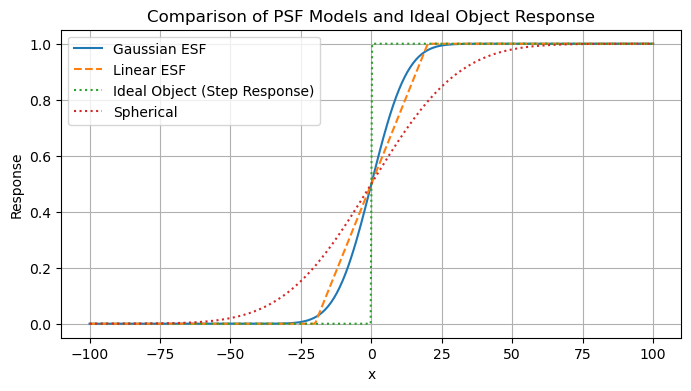

In [16]:
# ----------------------------------------------------------
# Input:
#   - Sensor data arrays and CHL data.
#   - Parameters: Exposure (F), Gamma (gamma), spatial increment (dx), constant (K).
#   - x coordinate values and ratio for PSF transition.
#
# Process:
#   - Compute normalized exposure using a hyperbolic tangent scaling.
#   - Evaluate PSFs (linear and Gaussian) based on the given ratio.
#   - Integrate sensor responses weighted by the PSF to compute the edge response.
#   - Plot the PSF models for visual comparison along with an ideal step response.
#
# Output:
#   - An edge response value for each sensor channel (red, green, blue).
#   - A plot comparing the Gaussian PSF, linear (ideal) PSF, and the ideal step response.
# ----------------------------------------------------------

# ---------------------- JIT-Compiled Functions ----------------------
from numba import njit
from math import erf as math_erf, tanh, sqrt, pi, exp, fabs
@njit
def Exposure_jit(x, F):
    """Compute the normalized exposure using a hyperbolic tangent scaling."""
    return np.tanh(F * x) / np.tanh(F)

@njit
def linear_ESF_jit(x: float, ratio: float) -> float:
    """Compute a linear PSF with a step-like behavior for negligible ratio."""
    if ratio < 1e-6:
        return 1.0 if x >= 0 else 0.0
    if x >= ratio:
        return 1.0
    elif x <= -ratio:
        return 0.0
    else:
        return 0.5 * (1 + x / ratio)

@njit
def gaussian_ESF_jit(x: float, ratio: float) -> float:
    """Compute a Gaussian-based PSF using a smooth error function transition."""
    if ratio < 1e-6:
        return 1.0 if x >= 0 else 0.0
    return 0.5 * (1.0 + math_erf(x / (sqrt(2) * 0.5 * ratio)))

@njit
def spherical_ESF_jit(x: float, ratio: float) -> float:
    """
    Spherical aberrated ESF using Gaussian model scaled by Strehl ratio:
    phi_sigma = 2pi * zernike_coef (in waves)
    Strehl S = exp(-phi_sigma^2)
    """
    zernike_coef = 0.1
    phi_sigma = 2 * pi * zernike_coef
    strehl = exp(-phi_sigma**2)
    if ratio < 1e-6:
        return strehl if x >= 0 else 0.0
    return 0.5 * (1.0 + math_erf(x / ratio * sqrt(strehl * 0.5)))


@njit
def compute_edge_jit(x: float, z: float, F: float, gamma: float, sensor_data, CHLdata, dx: float, K: float, psf_mode: str) -> float:
    """
    Compute the edge response by weighting sensor data with a PSF.
    
    For each CHL data point, calculates a weight (using a linear or Gaussian PSF) and
    accumulates a weighted sensor sum. The result is normalized and processed through
    an exposure function with gamma correction.
    """
    denom_factor = sqrt(4 * K**2 - 1)
    num = 0.0
    for n in range(len(CHLdata)):
        ratio = fabs((z - CHLdata[n]) / denom_factor)
         
        if psf_mode.lower() == "linear":
            weight = linear_ESF_jit(x, ratio)
        elif psf_mode.lower() == "gaussian":
            weight = gaussian_ESF_jit(x, ratio) 
        elif psf_mode.lower() == "spherical":
            weight = spherical_ESF_jit(x, ratio)
        else:
            weight = 0.0  # fallback for unknown mode
        num += sensor_data[n] * weight

    den = 0.0
    for val in sensor_data:
        den += val
    return Exposure_jit(num / den, F) ** gamma

# ---------------------- Edge Function Wrappers ----------------------
sensor_map = {"R": SensorReddata, "G": SensorGreendata, "B": SensorBluedata}

def Edge(color: str, x: float, z: float, F: float, gamma: float, CHLdata, dx: float, K: float, psf_mode: str = "gaussian") -> float:
    """
    General edge function wrapper for a specified sensor channel.
    
    Parameters:
        color (str): Sensor color, 'R', 'G', or 'B'.
        x, z, F, gamma, CHLdata, dx, K, psf_mode: Parameters passed to compute_edge_jit.
    
    Returns:
        float: Computed edge response.
    """
    sensor_data = sensor_map[color.upper()]
    return compute_edge_jit(x, z, F, gamma, sensor_data, CHLdata, dx, K, psf_mode)

# ---------------------- PSF Aliases & Plotting ----------------------
# Define x range and PSF transition parameter "ratio"
x_vals = np.linspace(-100, 100, 400)
ratio_value = 20  # Adjust as needed based on the sensor characteristics

# Compute PSF values for plotting
y_linear = np.array([linear_ESF_jit (val, ratio_value) for val in x_vals])
y_gaussian = np.array([gaussian_ESF_jit(val, ratio_value) for val in x_vals])
y_spherical = np.array([spherical_ESF_jit(val, ratio_value) for val in x_vals])
# The step response represents an ideal object boundary (no blurring)
y_ideal_step = np.where(x_vals < 0, 0, 1)

# Plot the PSF models and ideal object step response
plt.figure(figsize=(8, 4))
plt.plot(x_vals, y_gaussian, label=r'Gaussian ESF')
plt.plot(x_vals, y_linear, '--', label='Linear ESF')
plt.plot(x_vals, y_ideal_step, ':', label='Ideal Object (Step Response)')
plt.plot(x_vals, y_spherical, ':', label='Spherical')
plt.xlabel("x")
plt.ylabel("Response")
plt.title("Comparison of PSF Models and Ideal Object Response")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# --- Helper Functions for Color Fringe Calculations ---

def Farbsaum(x, z, F, gamma, CHLdata, psf_mode: str = "gaussian"):
    """
    Determine if a significant color difference exists (binary decision)
    using sensor edge responses.

    Returns:
        int: 1 if the absolute differences between channels exceed tol, else 0.
    """
    r = Edge("R", x, z, F, gamma, CHLdata, dx, K, psf_mode)
    g = Edge("G", x, z, F, gamma, CHLdata, dx, K, psf_mode)
    b = Edge("B", x, z, F, gamma, CHLdata, dx, K, psf_mode)
    return 1 if (abs(r - b) > tol or abs(r - g) > tol or abs(g - b) > tol) else 0


def Farbsaumbreite(z, F, gamma, CHLdata, psf_mode: str = "gaussian"):
    """
    Compute the overall color fringe width (binary method) for a given defocus (z).

    Returns:
        int: Aggregated binary width value.
    """
    xs = np.arange(-int(np.floor(xrange_val)), int(np.floor(xrange_val)) + 1)
    return np.sum([Farbsaum(x, z, F, gamma, CHLdata, psf_mode) for x in xs])


def ColorFringe(x, z, F, gamma, CHLdata, psf_mode: str = "gaussian"):
    """
    Compute the color fringe responses for a given x position.

    Returns:
        Tuple: (EdgeR, EdgeG, EdgeB) values.
    """
    return (
        Edge("R", x, z, F, gamma, CHLdata, dx, K, psf_mode),
        Edge("G", x, z, F, gamma, CHLdata, dx, K, psf_mode),
        Edge("B", x, z, F, gamma, CHLdata, dx, K, psf_mode)
    )

In [18]:
# (Ensure that global_CHLfit has been updated via get_modified_CHL_array before using.)
CHLdata_0 = global_CHLfit[:, 1] if global_CHLfit is not None else None

# --- Interactive Plotting for Edge Functions and Density Plot ---
def update_plots(z, F, gamma, model):
    """
    Interactive update for the edge spread function plots and the density plot.
    
    Parameters:
        z (float): Defocus position.
        F (float): Exposure parameter.
        gamma (float): Gamma correction factor.
        model (str): PSF model ('Linear PSF' or 'Gaussian PSF').
    """
    # Set psf_mode based on the model selection:
    psf_mode = "gaussian" if model == 'Gaussian PSF' else "linear"
    xs = np.linspace(-xrange_val, xrange_val, 400)
    
    # Compute the edge function values for each sensor channel using the generic Edge function.
    edgeR_vals = np.array([Edge("R", x, z, F, gamma, CHLdata_0, dx, K, psf_mode) for x in xs])
    edgeG_vals = np.array([Edge("G", x, z, F, gamma, CHLdata_0, dx, K, psf_mode) for x in xs])
    edgeB_vals = np.array([Edge("B", x, z, F, gamma, CHLdata_0, dx, K, psf_mode) for x in xs])
    
    # Compute the color difference binary decision for each x value.
    farb_vals = np.array([Farbsaum(x, z, F, gamma, CHLdata_0, psf_mode) for x in xs])
    
    # Plot the edge functions.
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(xs, edgeR_vals, label='EdgeR')
    ax1.plot(xs, edgeG_vals, label='EdgeG')
    ax1.plot(xs, edgeB_vals, label='EdgeB')
    ax1.plot(xs, farb_vals, label='Farbsaum')
    ax1.set_title(f"Edge Functions ({model})")
    ax1.set_xlabel("x")
    ax1.set_ylabel("Response")
    ax1.set_ylim(0, 1)
    ax1.legend()
    ax1.grid(True)
    
    # Create a density plot using ColorFringe (1D slice replicated vertically)
    ax2 = fig.add_subplot(1, 2, 2)
    X = np.linspace(-xrange_val, xrange_val, 200)
    Y = np.linspace(0, 0.5 * xrange_val, 100)
    XX, YY = np.meshgrid(X, Y)
    
    img = np.zeros((YY.shape[0], YY.shape[1], 3))
    for i in range(YY.shape[0]):
        for j in range(YY.shape[1]):
            img[i, j, :] = ColorFringe(XX[i, j], z, F, gamma, CHLdata_0, psf_mode)
    img = np.clip(img, 0, 1)
    ax2.imshow(img, extent=[-xrange_val, xrange_val, 0, 0.5 * xrange_val], aspect='auto')
    ax2.set_title("Density Plot (ColorFringe)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    
    plt.tight_layout()
    plt.show()
    
    # Compute and print overall color fringe width.
    width = Farbsaumbreite(z, F, gamma, CHLdata_0, psf_mode)
    print("Color width =", width)


# Interactive widget for edge functions.
interact(update_plots,
         z=FloatSlider(min=-defocusrange, max=defocusrange, step=1, value=0, description="Defocus"),
         F=FloatSlider(min=1, max=16, step=1, value=F_value, description="Exposure F"),
         gamma=FloatSlider(min=0.5, max=20, step=0.5, value=gamma_value, description="Gamma"),
         model=RadioButtons(options=['Gaussian PSF','Linear PSF'], description='PSF'))

NameError: name 'global_CHLfit' is not defined

In [ ]:
# --- Functions for Farbsaumbreite vs. Defocus Plot ---
dd = 10  # Step size for defocus values
z_vals = np.arange(-defocusrange, defocusrange + 1, dd)  # Defocus positions along the optical axis

def plot_farbs(F_value, label, psf_mode):
    """
    For each z in z_vals, calculate the "Farbsaumbreite" (color fringe width)
    using the binary method and plot these widths versus the defocus values.

    Parameters:
        F_value (float): The exposure parameter.
        label (str): Label for the plot.
        psf_mode (str): PSF mode ('linear' for Linear PSF; 'gaussian' for Gaussian PSF).
    
    Returns:
        np.ndarray: Data array with columns [z, Farbsaumbreite].
    """
    data = np.array([[z, Farbsaumbreite(z, F_value, gamma_value, CHLdata_0, psf_mode)] for z in z_vals])
    plt.plot(data[:, 0], data[:, 1], 'o-', markersize=3, label=label)
    return data


def plot_farbs_comparison(F_values=[2], weight_function_choice="Gaussian PSF"):
    """
    Plot Farbsaumbreite for various F values using the selected PSF model.

    Parameters:
        F_values (list): List of exposure (F) values.
        weight_function_choice (str): 'Linear PSF' or 'Gaussian PSF'.
    
    Returns:
        dict: A dictionary mapping each F value to its computed data array.
    """
    plt.figure(figsize=(8, 4))
    data_dict = {}
    psf_mode = "gaussian" if weight_function_choice == "Gaussian PSF" else "linear"
    
    for F_val in sorted(F_values):
        data_dict[F_val] = plot_farbs(F_val, f"F={F_val}", psf_mode)
    
    model_name = weight_function_choice
    plt.title(f"Farbsaumbreite for various F values (g=gamma_value) using {model_name} (Binary method)")
    plt.xlabel("z (defocus)")
    plt.ylabel("Farbsaumbreite")
    plt.legend()
    plt.grid(True)
    plt.show()
    return data_dict


def interactive_plot(F_values, weight_function_choice):
    """
    Interactive function to plot Farbsaumbreite comparison for selected F values
    and PSF model.
    
    Parameters:
        F_values (list): List of exposure F values.
        weight_function_choice (str): 'Linear PSF' or 'Gaussian PSF'.
    """
    F_values = sorted(F_values)
    plot_farbs_comparison(F_values=F_values, weight_function_choice=weight_function_choice)


# Interactive widgets for Farbsaumbreite plot.
F_values_widget = widgets.SelectMultiple(
    options=[1, 2, 4, 8, 16],
    value=[1, 2, 4, 8],
    description='F values',
    disabled=False
)

weight_function_widget = widgets.RadioButtons(
    options=['Gaussian PSF', 'Linear PSF'],
    value='Gaussian PSF',
    description='PSF',
    disabled=False
)

# Measure the runtime of the interactive plot setup.
start_time = time.time()  # Start timer
interact(interactive_plot, 
         F_values=F_values_widget, 
         weight_function_choice=weight_function_widget)
end_time = time.time()  # End timer

print("Runtime: {:.3f} seconds".format(end_time - start_time))


In [ ]:
def evaluate_params(params):
    """
    Evaluate a single (x_shift, tilt) parameter combination by computing the 
    aggregated Farbsaumbreite value over the range of defocus positions.

    For each (x_shift, tilt):
      - Compute the modified CHL curve and extract CHL data.
      - For each defocus position (z) in z_vals, calculate the Farbsaumbreite.
      - Aggregate these values using the selected aggregation_mode (mean, mean_center, or max).
        For the "mean_center" mode, only the range between the left and right global maximum
        fringe values (based on their positions in the array) is averaged.

    Parameters:
        params (tuple): (x_shift, tilt)

    Returns:
        tuple: (x_shift, tilt, aggregated_width)
    """
    x_shift, tilt = params
    # Compute the modified CHL curve for the current parameters.
    CHL_matrix = extract_sampled_modified_values_overall(x_shift, tilt)
    CHLdata_local = CHL_matrix[:, 1]
    
    # Calculate Farbsaumbreite for each defocus position.
    # Here, gamma is set to 1 and the PSF is fixed as "gaussian".
    fringe_values = [
        Farbsaumbreite(z, F_value, 1, CHLdata_local, psf_mode="gaussian")
        for z in z_vals
    ]
    
    # Aggregate the fringe values based on the selected aggregation_mode.
    if aggregation_mode == "mean_center":
        # Split the fringe values at the midpoint.
        mid_index = len(fringe_values) // 2
        
        # Find the index of the maximum value in the left segment (from the start to the midpoint).
        left_segment = fringe_values[:mid_index+1]  # include midpoint for safety
        left_max_idx = np.argmax(left_segment)
        
        # Find the index of the maximum value in the right segment (from the midpoint to the end).
        right_segment = fringe_values[mid_index:]
        right_max_idx = np.argmax(right_segment) + mid_index  # adjust index relative to whole array
        
        # Use the smaller index as left and the larger as right.
        left_index = min(left_max_idx, right_max_idx)
        right_index = max(left_max_idx, right_max_idx)
        
        # Compute the mean only over the values between (and including) the two global maximum indices.
        aggregated_width = np.mean(fringe_values[left_index:right_index+1])
    
    elif aggregation_mode == "max":
        aggregated_width = np.max(fringe_values)
    elif aggregation_mode == "mean":
        aggregated_width = np.mean(fringe_values)
    else:
        aggregated_width = np.max(fringe_values)  # default fallback
    
    return (x_shift, tilt, aggregated_width)


def grid_search():
    """
    Perform a grid search over x_shift and tilt parameters using parallel threads.

    Returns:
        tuple: (best_params, results_array, x_shift_values, tilt_values)
    """
    # Define grid ranges for x_shift and tilt.
    x_shift_values = np.linspace(-80, 80, num=21)
    tilt_values = np.linspace(-0.8, 0.8, num=21)
    param_grid = [(x_shift, tilt) for x_shift in x_shift_values for tilt in tilt_values]
    
    # Evaluate each parameter combination in parallel.
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(evaluate_params, param_grid))
    
    results_array = np.array(results)
    # Find the combination with the smallest aggregated fringe width.
    min_index = np.argmin(results_array[:, 2])
    best_params = results_array[min_index]
    return best_params, results_array, x_shift_values, tilt_values
